In [1]:
from IPython import get_ipython
import json
import plotly
import math
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
from ipywidgets import Accordion, IntSlider, Text
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import pandas as pd
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

In [2]:
def Loads(f,G):
    df_excel = pd.read_excel(r"C:\Users\ilya_\Downloads\ВУ_ОНГКМ_1333_к1609_Траектория_V4привязка_к_ГИС_ЭК_06_08_2020_1.xlsx")
    df = df_excel.loc[13:].reset_index(drop=True).rename(columns=df_excel.loc[12])
    df = df[['Глубина по стволу, м','Зенитный угол, град','Азимут картогр, Grid, град','Глубина по вертикали, м','С-Ю, м','В-З,м','Пространст. интенсивность, град/10 м']]
    # Дельта L
    df["shift_L"] = df["Глубина по стволу, м"].shift(-1).fillna(0)
    df["delta_L"] = df['shift_L'] - df['Глубина по стволу, м']

    # Перевод в радианы
    df["Alpha"] = df["Зенитный угол, град"].apply(math.radians)
    df["Phi"] = df["Азимут картогр, Grid, град"].apply(math.radians)

    # Дельта альфи 
    df["shift_alpha"] = df["Alpha"].shift(-1).fillna(0)
    df["delta_alpha"] = df['shift_alpha'] - df['Alpha']

    # Среднее значение ближайших альфа 
    df["Avg_alpha"] = (df['shift_alpha'] + df['Alpha'])/2

    # Дельта фи
    df["shift_phi"] = df["Phi"].shift(-1).fillna(0)
    df["delta_phi"] = df['shift_phi'] - df['Phi']

    # Мяу и Бета 
    df["MIU"] = f
    df["Beta"] = 0.87

    # Погонный вес
    df["w"] = 26
    df["w"] = df["w"].apply(float)

    # Косинус альфа и синус альфа
    df['cos_alpha'] = df["Alpha"].apply(math.cos)
    df["sin_alpha"] = df["Alpha"].apply(math.sin)
    df["sin_shift"] = df["sin_alpha"].shift(-1).fillna(0)
    df["sin_dif_alpha"] = df['sin_shift'] - df['sin_alpha']
    df["sin_avr_alpha"] = df["Avg_alpha"].apply(math.sin)

    for i in range(len(df)):
        if df.loc[len(df)-1-i,"sin_dif_alpha"]<0:
            df.loc[len(df)-1-i,"sin_dif_alpha"] = 0

    # Находим коэффициент К
    df["K"] = ((df["delta_alpha"]/df["delta_L"])**2+(df["delta_phi"]/df["delta_L"])**2*(df["sin_avr_alpha"])**2)**0.5
    # Вносим столбец с нулевым значением F
    df['F'] = 0
    # Расчитываем Тета
    df['Teta'] = df["delta_L"]*df["K"]
    # Считаем экспоненту 
    df['for_exp'] = df["Teta"]*df["MIU"]
    df['exp'] =  df["for_exp"].apply(math.exp).fillna(0)

    # Осевая нагрузка
    for i in range(len(df)-1):
        if int(df.loc[len(df)-1-i,"delta_alpha"])==0:
            df.loc[len(df)-2-i,"F"] = df.loc[len(df)-1-i,"F"]*df.loc[len(df)-1-i,"exp"] + df.loc[len(df)-1-i,"Beta"]*df.loc[len(df)-1-i,"w"]*df.loc[len(df)-1-i,"delta_L"]*df.loc[len(df)-1-i,"cos_alpha"]
        else:
            df.loc[len(df)-2-i,"F"] = df.loc[len(df)-1-i,"F"]*df.loc[len(df)-1-i,"exp"] + df.loc[len(df)-1-i,"Beta"]*df.loc[len(df)-1-i,"w"]*df.loc[len(df)-1-i,"delta_L"]*(df.loc[len(df)-1-i,"sin_dif_alpha"]/df.loc[len(df)-1-i,"delta_alpha"])
    df['ff'] = np.linspace(max(df['F']),0,len(df))
    df['Difference'] = df['F'] - df['ff']
    df_load = df[['Глубина по стволу, м','Зенитный угол, град','Азимут картогр, Grid, град','Глубина по вертикали, м','С-Ю, м','В-З,м','Пространст. интенсивность, град/10 м','F','Difference']]
    df_load["F"] = df_load["F"].apply(lambda x:x-G*1000) 
    return df_load.copy()

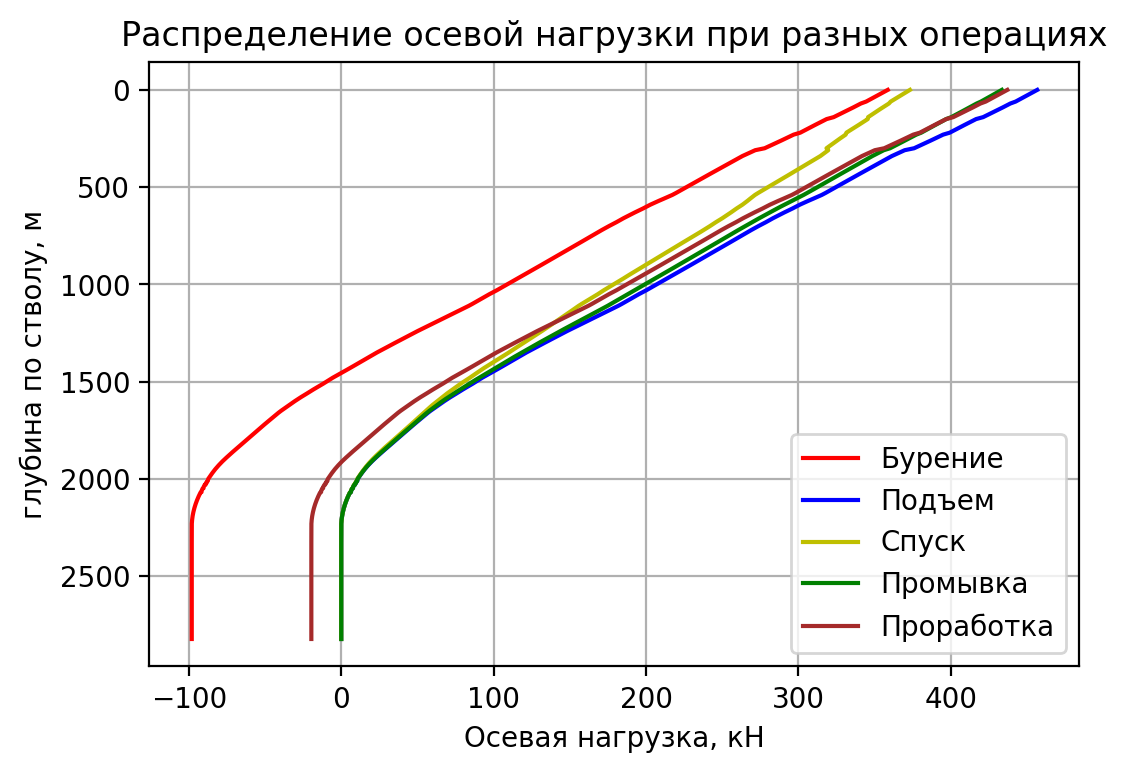

In [3]:
operations = [["Бурение",0.1,10],["Подъем",0.1,0],["Спуск",-0.1,0],["Промывка",0.05,0],["Проработка",0.1,2],]
colours = ["r","b","y","g","brown"]
fig = plt.figure(dpi = 200)
ax = fig.add_subplot(111)
for l,i in enumerate(operations):
    df_load = Loads(i[1],i[2])
    df_load["F"] = df_load["F"]*9.81/1000
    ax.plot(df_load["F"],df_load["Глубина по стволу, м"], label = i[0],color = colours[l] )
    ax.invert_yaxis()
    ax.legend(loc = 'lower right')
    ax.set_xlabel('Осевая нагрузка, кН')
    ax.set_ylabel('глубина по стволу, м')
    ax.set_title("Распределение осевой нагрузки при разных операциях")
    ax.grid()

In [4]:
global df

df = Loads(0.1,5)
# Допустим нашли разницу между реальным и теоретическим весом

%matplotlib inline
import ipywidgets
slider = ipywidgets.IntSlider(value=0,
                              min=0,
                              max=max(df['Глубина по вертикали, м'].tolist()),
                              step=1,
                              description='Глубина:',
                              disabled=False,
                              continuous_update=False,
                              orientation='horizontal',
                              readout=True,
                              readout_format='d')

def intA(trajectory):
    global df
    xp = df['Глубина по вертикали, м'].tolist()
    
    fp = df['С-Ю, м'].tolist()
    
    sp = df['В-З,м'].tolist()
    
    F = df['F'].tolist()
    
    Int = df['Пространст. интенсивность, град/10 м'].tolist()
    Dif = df['Difference'].tolist()
    
    a = np.interp(trajectory, xp, fp)
    
    b = np.interp(trajectory, xp, sp)
    
    c = np.interp(trajectory, xp, F)
    
    d = np.interp(trajectory, xp, Int)
    
    e = np.interp(trajectory, xp, Dif)
    
#     return print(' С-Ю,м:',a,'\n','\n','В-З,м:',b,'\n','\n','F,H:',c,'\n','Разница с реальным весом:',e,'\n','\n','Пространст. интенсивность, град/10 м:',d)
    print('Растягивающая нагрузка, F:',round(c/101.971621,1),'кН','\n','\n','Пространст. интенсивность, град/10 м:',round(d,1))
qw = "Спуск"
global qw

def red_point(trajectory):
    global df
    xp = df['Глубина по вертикали, м'].tolist()
    fp = df['С-Ю, м'].tolist()
    sp = df['В-З,м'].tolist()
    
    a = np.interp(trajectory, xp, fp)
    b = np.interp(trajectory, xp, sp)
    c = np.interp(trajectory + 1, xp, fp)
    d = np.interp(trajectory + 1, xp, sp)
    e = np.interp(trajectory + 2, xp, fp)
    g = np.interp(trajectory + 2, xp, sp)
    fig = plt.figure(figsize=(12,8))
    ax_3d = fig.add_subplot(projection='3d')
    ax_3d.set_xlabel('С-Ю', fontsize = 10)
    ax_3d.set_ylabel('В-З', fontsize = 10)
    ax_3d.set_zlabel('Глубина по вертикали, м', fontsize = 10)
    ax_3d.set_title("Траектория ствола скважины", fontsize = 15)
    ax_3d.plot(fp,sp,xp,linewidth=2, color='blue')
    ax_3d.invert_zaxis()
    ax_3d.plot([a,c,e],[b,d,g],[trajectory,trajectory + 1,trajectory + 2],linewidth=6, color='red')
    print(qw)
    plt.show()
    

# ipywidgets.interact(red_point,trajectory=slider)
# ipywidgets.interact(intA, trajectory=slider)

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
def f(operation):
    global df
    global qw
    qw=operation
    
    if operation=="Спуск":
        print("коэффициент трения  μ = -0.1")
        df = Loads(-0.1,0)
        ipywidgets.interact(red_point,trajectory=slider)
        ipywidgets.interact(intA, trajectory=slider)
    if operation=="Подъем":
        print("коэффициент трения  μ = 0.1")
        df = Loads(0.1,0)
        ipywidgets.interact(red_point,trajectory=slider)
        ipywidgets.interact(intA, trajectory=slider)
        
    if operation == "Бурение":
        print("коэффициент трения  μ = 0.1\nнагрузка на долото G = 100 кН")
        df = Loads(0.1,10)
        ipywidgets.interact(red_point,trajectory=slider)
        ipywidgets.interact(intA, trajectory=slider)
        
    if operation == "Проработка":
        print("коэффициент трения  μ = 0.1\nнагрузка на долото G = 20 кН")
        df = Loads(0.1,2)
        ipywidgets.interact(red_point,trajectory=slider)
        ipywidgets.interact(intA, trajectory=slider)
        
    if operation == "Промывка":
        print("коэффициент трения  μ = 0.05")
        df = Loads(0.05,0)
        ipywidgets.interact(red_point,trajectory=slider)
        ipywidgets.interact(intA, trajectory=slider)
        
interact(f, operation=["Спуск",'Подъем','Бурение',"Проработка","Промывка"])



interactive(children=(Dropdown(description='operation', options=('Спуск', 'Подъем', 'Бурение', 'Проработка', '…

<function __main__.f(operation)>